# CIS4020 Group Project - Movie Recommendations

### Step 0: Imports & environment setup
__Purpose:__ Bring in data access (Kaggle), data wrangling (pandas/numpy), plotting (matplotlib),
and deep-learning utilities (Keras). Later cells will use these for loading a movie dataset,
exploring it, and building a CF model/baseline NN.


In [ ]:
# Data source helper for pulling datasets directly from Kaggle into Colab runtime.
# (Requires Kaggle API credentials configured in the environment.)
import kagglehub

# Core data wrangling and numerics.
import pandas as pd
import numpy as np

# Quick EDA and diagnostic plots (distributions, learning curves, etc.).
import matplotlib.pyplot as plt

# Keras will be used for any neural models/baselines (e.g., MF via embeddings, NCF).
import keras
from keras import layers   # Layer building blocks: Embedding, Dense, Dropout, etc.
from keras import ops      # Backend tensor ops (shape-safe math independent of TF/JAX backend).


### Step 1: Download Datasets from Kaggle
__Purpose:__ Retrieve the MovieLens 32M ratings dataset (user–movie interactions) and the TMDB
metadata dataset (movie details like genres, release dates, etc.) using `kagglehub`.
These datasets will later be merged to provide both rating behavior and movie attributes.


In [ ]:
movielens_download_path = kagglehub.dataset_download("justsahil/movielens-32m")
print('\nMovieLens dataset downloaded to: ', movielens_download_path)

tmdb_download_path = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")
print('\nTMDB movie download path: ', tmdb_download_path)

100%|██████████| 231M/231M [00:01<00:00, 125MB/s]

Extracting files...



MovieLens dataset downloaded to:  /root/.cache/kagglehub/datasets/justsahil/movielens-32m/versions/1
Using Colab cache for faster access to the 'tmdb-movies-dataset-2023-930k-movies' dataset.

TMDB movie download path:  /kaggle/input/tmdb-movies-dataset-2023-930k-movies


### Step 2: Load and Prepare MovieLens & TMDB Datasets
__Purpose:__ Load CSV files into Pandas DataFrames for both user - movie interaction data (MovieLens)
and movie metadata (TMDB). Then sample a manageable subset of ratings for faster experimentation
and merge metadata to enrich movie information.


In [ ]:
# Load dataframes

# print('Loading movielens movies...')

# Contains basic movie info from MovieLens (movieId, title, genres)
# movies_df = pd.read_csv(movielens_download_path + '/ml-32m/movies.csv')
# print("Number of movies:", len(movies_df))
# print()

print('Loading TMDB movies...')

# Contains detailed movie metadata (title, release_date, popularity, genres, overview, etc.)
# Using 'id' as the index since each row corresponds to a unique TMDB movie ID
tmdb_movies_df = pd.read_csv(tmdb_download_path + '/TMDB_movie_dataset_v11.csv', index_col='id')
print("Number of TMDB movies:", len(tmdb_movies_df))
print()

print('Loading links...')

# Provides mapping between MovieLens movieId and external IDs like IMDb and TMDB
links_df = pd.read_csv(movielens_download_path + '/ml-32m/links.csv')
print("Number of links:", len(links_df))
print()

print('Loading ratings...')

# Core dataset containing userId, movieId, rating, and timestamp
# Used to construct the user–item interaction matrix for collaborative filtering
ratings_df = pd.read_csv(movielens_download_path + '/ml-32m/ratings.csv')
print("Number of ratings:", len(ratings_df))
print()

print('Taking random sample of ratings...')

# To speed up computation, randomly sample 100k ratings from the full dataset
# (random_state ensures reproducibility)
ratings_df = ratings_df.sample(n=100_000, random_state=69420)
print("Number of ratings:", len(ratings_df))
print()

# Get the set of unique movie IDs from your ratings sample
sampled_movie_ids = ratings_df['movieId'].unique()
print(f"Number of unique movies in sample: {len(sampled_movie_ids)}")

# Filter links_df to only include movies that are in our sample
links_df = links_df[links_df['movieId'].isin(sampled_movie_ids)]
print(f"Number of links after filtering: {len(links_df)}")

# Merge movie metadata from TMDB onto MovieLens using the TMDB ID mapping
# 'how="left"' ensures we keep all MovieLens entries even if some TMDB data is missing
movies_df = links_df.join(tmdb_movies_df, on='tmdbId', how='left')

# Replace any missing plot summaries with an empty string to avoid NaN issues later
movies_df['overview'] = movies_df['overview'].fillna('')

# Load user-provided tags (comments/keywords) if needed for content-based features
# print('Loading tags...')
# tags_df = pd.read_csv(path+'/ml-32m/tags.csv')
# print("Number of tags:", len(tags_df))
# print()


Loading TMDB movies...
Number of TMDB movies: 1323558

Loading links...
Number of links: 87585

Loading ratings...
Number of ratings: 32000204

Taking random sample of ratings...
Number of ratings: 100000

Number of unique movies in sample: 11224
Number of links after filtering: 11224


### Step 4: Inspect the Combined Movie Metadata DataFrame
__Purpose:__ Confirm that the join between `links_df` (MovieLens–TMDB mapping) and `tmdb_movies_df`
succeeded. This DataFrame should now contain both MovieLens IDs and rich TMDB metadata such as
title, genres, release date, etc...


In [ ]:
# Display the merged movie metadata DataFrame.
# Each row should correspond to a MovieLens movieId matched with its TMDB metadata (if available).
# Expected columns include:
#   - movieId, imdbId, tmdbId (from links_df)
#   - title, release_date, genres, overview, popularity, etc. (from TMDB)
# Checking this helps verify the merge alignment and spot any missing values.
movies_df


,movieId,imdbId,tmdbId,title,vote_average,vote_count,status,release_date,revenue,runtime,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,1,114709,862.0,Toy Story,7.971,17152.0,Released,1995-10-30,394400000.0,81.0,...,Toy Story,"Led by Woody, Andy's toys live happily in his ...",78.404,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,Hang on for the comedy that goes to infinity a...,"Animation, Adventure, Family, Comedy",Pixar,United States of America,English,"rescue, friendship, mission, martial arts, jea..."
1,2,113497,8844.0,Jumanji,7.239,9833.0,Released,1995-12-15,262821940.0,104.0,...,Jumanji,When siblings Judy and Peter discover an encha...,13.444,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg,Roll the dice and unleash the excitement!,"Adventure, Fantasy, Family","TriStar Pictures, Interscope Communications, T...",United States of America,"English, French","giant insect, board game, disappearance, jungl..."
2,3,113228,15602.0,Grumpier Old Men,6.476,347.0,Released,1995-12-22,71500000.0,101.0,...,Grumpier Old Men,A family wedding reignites the ancient feud be...,14.815,/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg,Still Yelling. Still Fighting. Still Ready for...,"Romance, Comedy","Lancaster Gate, Warner Bros. Pictures",United States of America,English,"fishing, sequel, old man, best friend, wedding..."
3,4,114885,31357.0,Waiting to Exhale,6.183,142.0,Released,1995-12-22,81452156.0,127.0,...,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",14.451,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,Friends are the people who let you be yourself...,"Comedy, Drama, Romance",20th Century Fox,United States of America,English,"based on novel or book, interracial relationsh..."
4,5,113041,11862.0,Father of the Bride Part II,6.228,659.0,Released,1995-12-08,76594107.0,106.0,...,Father of the Bride Part II,Just when George Banks has recovered from his ...,14.537,/rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg,Just when his world is back to normal... he's ...,"Comedy, Family","Touchstone Pictures, Sandollar Productions",United States of America,English,"daughter, baby, parent child relationship, mid..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86610,289131,3917710,823395.0,The Baker,6.200,10.0,Released,2023-07-27,0.0,103.0,...,The Baker,"A quiet, stoic man, lives a monk-like existenc...",12.654,/ocUrOchwIIageWWrHKiiVgUc06L.jpg,Careful who you cross.,"Action, Drama, Crime, Thriller, Mystery","Productivity Media, Darius Films",Canada,English,"drugs, violence"
86663,289297,13603966,724209.0,Heart of Stone,6.901,1166.0,Released,2023-08-09,0.0,124.0,...,Heart of Stone,An intelligence operative for a shadowy global...,336.927,/vB8o2p4ETnrfiWEgVxHmHWP9yRl.jpg,Defy the odds,"Thriller, Action","Skydance, Pilot Wave Motion Pictures, Mockingb...",United States of America,English,"mission, saving the world, undercover agent, u..."
86920,290169,21940934,1082425.0,Miguel Wants to Fight,6.600,5.0,Released,2023-08-16,0.0,75.0,...,Miguel Wants to Fight,In a neighborhood where fighting is stitched i...,13.353,/xaeQ0aWve7rNbrht4a3l3onM9qQ.jpg,He's pretty sure he's ready for this,Comedy,American High,United States of America,English,coming of age
87028,290573,11858890,670292.0,The Creator,7.500,107.0,Released,2023-09-27,0.0,134.0,...,The Creator,Amid a future war between the human race and t...,496.806,/vBZ0qvaRxqEhZwl6LWmruJqWE8Z.jpg,This is a fight for our very existence.,"Science Fiction, Action, Thriller","New Regency Pictures, Entertainment One, Regen...","Canada, United States of America","English, Japanese, Thai, Vietnamese","artificial intelligence (a.i.), asia, distant ..."


### Step 5: Inspect the MovieLens–TMDB Links DataFrame
__Purpose:__ Verify that the mapping between MovieLens `movieId` values and external IDs
(`imdbId`, `tmdbId`) loaded correctly. This linkage is crucial for merging MovieLens ratings with TMDB metadata.


In [ ]:
# Display the MovieLens–TMDB links DataFrame.
# Each row provides ID mappings for one movie:
#   - movieId: MovieLens unique identifier
#   - imdbId: corresponding IMDb ID
#   - tmdbId: corresponding TMDB ID (used to merge with tmdb_movies_df)
# Confirming these values ensures that later joins between datasets will align correctly.
links_df


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
86610,289131,3917710,823395.0
86663,289297,13603966,724209.0
86920,290169,21940934,1082425.0
87028,290573,11858890,670292.0


### Step 6: Inspect the Ratings DataFrame
__Purpose:__ Confirm that the MovieLens ratings dataset loaded and sampled correctly.
This DataFrame contains the user–item interaction data used for collaborative filtering.


In [ ]:
# Display the sampled MovieLens ratings DataFrame.
# Expected columns:
#   - userId: unique identifier for each user
#   - movieId: unique identifier for each movie (links to movies_df / links_df)
#   - rating: user’s rating of that movie (typically on a 0.5–5.0 scale)
#   - timestamp: when the rating was given (useful for temporal analysis if needed)
# Since we took a 100,000-row random sample earlier, this view helps confirm that
# the sampling worked and the data is in the expected format.
ratings_df


,userId,movieId,rating,timestamp
18114852,113253,3201,1.0,960845871
1179752,7631,12,3.5,1403638724
6262374,39056,5574,3.0,1432706304
28049890,175712,2948,3.0,1117285603
284231,1819,1777,3.0,1513572972
...,...,...,...,...
27565790,172944,50,3.5,1165996163
18854216,118005,2919,5.0,1141539648
4387819,27503,3452,3.5,1105309139
21427400,133982,193749,3.5,1537468818


### Step 7: Explore Rating Value Statistics
__Purpose:__ Summarize the distribution of user ratings to understand overall tendencies.
This helps confirm data quality and provides intuition
for model normalization or bias handling later.


In [ ]:
# Display summary statistics for the 'rating' column.
print("mean ratings per user: ", ratings_df.groupby('userId').size().mean())

# Outputs include:
#   - count: number of ratings in the sampled dataset
#   - mean: average rating (often around 3.5 for MovieLens data)
#   - std: standard deviation, indicating rating variability
#   - min/max: range of possible rating values (should be 0.5 to 5.0)
#   - 25%, 50%, 75%: quartiles showing how ratings are distributed
ratings_df['rating'].describe()


mean ratings per user:  1.6901884560128455


,rating
count,100000.000000
mean,3.546290
std,1.062049
min,0.500000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


### Step 8: Collaborative Filtering
__Purpose:__ Remap sparse `userId` and `movieId` values to contiguous 0…N−1 indices required by
embedding layers. Also cast ratings to `float32` for Keras.

__Reference:__ https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [ ]:
### Try (Neural) Collaborative Filtering
# ref: https://keras.io/examples/structured_data/collaborative_filtering_movielens/

# Collect unique user IDs from the sampled ratings.
# We will encode them as [0, 1, 2, ...] for use with embedding layers.
user_ids = ratings_df["userId"].unique()

# Two-way maps: raw MovieLens userId <-> encoded contiguous index
# Note: enumerate() order depends on the order returned by .unique() (stable for this Series).
userId_to_encodedUserId = {x: i for i, x in enumerate(user_ids)}
encodedUserId_to_userId = {i: x for i, x in enumerate(user_ids)}

# Repeat the same process for movies so we get contiguous item indices for embeddings.
movie_ids = ratings_df["movieId"].unique()
movieId_to_encodedMovieId = {x: i for i, x in enumerate(movie_ids)}
encodedMovieId_to_movieId = {i: x for i, x in enumerate(movie_ids)}

# Add encoded columns expected by the model (Keras will take these integer indices).
ratings_df['user'] = ratings_df['userId'].map(userId_to_encodedUserId)
ratings_df['movie'] = ratings_df['movieId'].map(movieId_to_encodedMovieId)

# Track the vocabulary sizes for embedding layers.
num_users = len(user_ids)
num_movies = len(movie_ids)
print('Number of users:', num_users)
print('Number of movies:', num_movies)

# Ensure ratings are float32 for Keras/Tensor ops (saves memory vs float64).
ratings_df['rating'] = ratings_df['rating'].values.astype(np.float32)


Number of users: 59165
Number of movies: 11224


### Step 9: Inspect Encoded Ratings DataFrame
__Purpose:__ Confirm that new columns (`user`, `movie`) were added correctly after encoding
`userId` and `movieId` into contiguous integer indices for the neural CF model.


In [ ]:
# Display the ratings DataFrame after encoding user and movie IDs.
# Expected columns now:
#   - userId: original MovieLens user identifier
#   - movieId: original MovieLens movie identifier
#   - rating: float32 rating value (0.5–5.0)
#   - timestamp: original time of rating
#   - user: encoded user index (0 to num_users-1)
#   - movie: encoded movie index (0 to num_movies-1)
# Checking this ensures the mappings worked correctly and there are no missing (NaN) indices.
ratings_df


,userId,movieId,rating,timestamp,user,movie
18114852,113253,3201,1.0,960845871,0,0
1179752,7631,12,3.5,1403638724,1,1
6262374,39056,5574,3.0,1432706304,2,2
28049890,175712,2948,3.0,1117285603,3,3
284231,1819,1777,3.0,1513572972,4,4
...,...,...,...,...,...,...
27565790,172944,50,3.5,1165996163,59163,139
18854216,118005,2919,5.0,1141539648,42675,4564
4387819,27503,3452,3.5,1105309139,3427,2339
21427400,133982,193749,3.5,1537468818,21268,11223


### Step 10: Prepare Training and Validation Data
__Purpose:__ Split the encoded user–movie pairs and normalized ratings into training and validation sets.
Normalization helps stabilize training, and the split enables model evaluation on unseen data.


In [ ]:
# Prepare training and validation data

# Note: ratings_df is already a random sample (100,000 rows), so we can safely split it sequentially.
# 'x' will contain user–movie index pairs; 'y' will contain normalized ratings.

x = ratings_df[['user', 'movie']].values   # Shape: (n_samples, 2)
y = ratings_df['rating'].values            # Shape: (n_samples,)

# Find min and max ratings to normalize between 0 and 1 for stable neural training.
# Neural networks converge faster and more reliably when targets are on a small, consistent scale.
min_rating = np.min(y)
max_rating = np.max(y)

# Normalize ratings: (rating - min) / (max - min)
# Original MovieLens scale is typically 0.5–5.0 → normalized 0.0–1.0
y = (y - min_rating) / (max_rating - min_rating)

# Split data into training (90%) and validation (10%) sets.
# Sequential split is fine since the data was previously randomized via sample().
train_indicies = int(0.9 * len(x))

x_train, x_valid, y_train, y_valid = (
    x[:train_indicies],
    x[train_indicies:],
    y[:train_indicies],
    y[train_indicies:],
)

# Print dataset sizes to confirm the split.
print('xtrain size:', len(x_train))
print('xvalid size:', len(x_valid))
print('ytrain size:', len(y_train))
print('yvalid size:', len(y_valid))


xtrain size: 90000
xvalid size: 10000
ytrain size: 90000
yvalid size: 10000


### Step 11: Define a Neural Collaborative Filtering (MF) Model
__Purpose:__ Learn low-dimensional representations (embeddings) for users and movies.  
Prediction = (user embedding) · (movie embedding) + user bias + movie bias, squashed with a sigmoid to 0–1.  
Notes:
- `EMBEDDING_SIZE` controls representation capacity; larger = more expressive, higher overfit risk.  
- Bias terms capture global user/movie tendencies (lenient rater, universally-liked movie).  
- Output is 0–1 because we normalized ratings earlier; rescale back to original rating range when needed.


In [ ]:
# Create the model

EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super().__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size

    # User embedding matrix: shape (num_users, k)
    # init works fine for dot-product models; L2 discourages overly large factors (overfitting).
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6),
    )
    # Per-user bias (scalar) to capture tendency to rate high/low regardless of item.
    self.user_bias = layers.Embedding(num_users, 1)

    # Movie embedding matrix: shape (num_movies, k)
    self.movie_embedding = layers.Embedding(
        num_movies,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-6),
    )
    # Per-movie bias (scalar) to capture overall item popularity/quality.
    self.movie_bias = layers.Embedding(num_movies, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])   # (batch_size, k)
    user_bias   = self.user_bias(inputs[:, 0])        # (batch_size, 1)

    movie_vector = self.movie_embedding(inputs[:, 1]) # (batch_size, k)
    movie_bias   = self.movie_bias(inputs[:, 1])      # (batch_size, 1)

    # Dot product between user and movie latent vectors → (batch_size, 1)
    dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)

    # Add learned biases
    x = dot_user_movie + user_bias + movie_bias

    # Map predictions to [0, 1] since targets were min–max normalized
    return ops.nn.sigmoid(x)


cf_model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

# Compile with optimizer and loss.
cf_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

### Step 12: Train the Neural CF Model
__Purpose:__ Fit the embedding-based recommender on encoded `(user, movie)` pairs with normalized ratings.  


In [ ]:
# Train the model (want to learn how movies are rated by specific users(?))
# I recommend switching the runtime type here to T4 GPU for parallelization
# X - users and movies
# Y - ratings
history = cf_model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_valid, y_valid),
)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6852 - val_loss: 0.6626
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6387 - val_loss: 0.6610
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6171 - val_loss: 0.6572
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6165 - val_loss: 0.6570
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6238 - val_loss: 0.6530


### Step 13: Inspect Validation Loss
__Purpose:__ Check the loss achieved on the validation set after training. This helps evaluate how well the model generalizes to unseen user–movie pairs.


In [ ]:
print("loss: ")
print(history.history['loss'])

print("loss during validation: ")
print(history.history['val_loss'])

loss: 
[0.6774935126304626, 0.6245822310447693, 0.6158403158187866, 0.6159824728965759, 0.6209938526153564]
loss during validation: 
[0.6626124978065491, 0.6609626412391663, 0.6572210788726807, 0.6569616794586182, 0.6529509425163269]


### Step 14: Plot Training vs Validation Loss
__Purpose:__ Visualize how the model’s loss changed over epochs for both training and validation sets. This helps detect underfitting or overfitting by comparing the two loss curves.


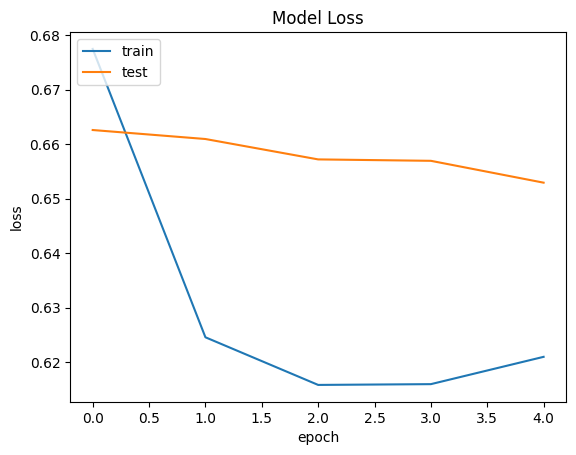

In [ ]:
# Plot training and validation loss curves over epochs
plt.plot(history.history['loss'])      # Training loss
plt.plot(history.history['val_loss'])  # Validation loss
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

# The legend labels the two lines:
#  - 'train' → loss on training data
#  - 'test'  → loss on validation data
plt.legend(['train', 'test'], loc='upper left')

# Display the plot
plt.show()


### Step 15: Generate CF Recommendations for One User
__Purpose:__ Pick a user, score all **unwatched** movies with the trained CF model, and return the
`top_n` highest-predicted movies for that user.

In [ ]:
def get_top_rated_movies(user_id: int, top_n=20) -> list[int, float]:
    """
    Get the top-rated movies for a given user.
    Returns list of (movieIdl rating) tuples for the top-rated movies.
    """
    top_rated_movies = (
        ratings_df[ratings_df.userId == user_id]
            .sort_values(by='rating', ascending=False)
            .head(top_n)
            [['movieId', 'rating']]
    )
    top_rated_movies_list = list(
        top_rated_movies.itertuples(index=False, name=None)
    )
    return top_rated_movies_list

def get_movie_extended_title(movie_id: int) -> str:
    movie_row = movies_df[movies_df.movieId == movie_id].iloc[0]
    title = movie_row['title']

    if pd.isna(title):
        return '<unknown>'

    year = movie_row['release_date'].split('-')[0]
    genres = movie_row['genres']

    return f"{title} ({year}) - {genres}"

In [ ]:
all_encoded_movie_ids = np.array([movieId_to_encodedMovieId[m] for m in movie_ids])

def get_collaborative_filtering_recommendations(
        user_id: int,
        candidate_movie_ids: np.ndarray | None = None,
        top_n = 10,
        source_df: pd.DataFrame = ratings_df,
        user_to_watched: dict[int, np.ndarray] | None = None,
    ) -> list[int]:
    """
    Recommend top_n movies for a given user using the trained CF model.

    Steps:
      1) If movie_ids is not provided, finds movies that user had not watched.
      2) Create a (num_candidates x 2) array of [encoded_user, encoded_movie] pairs.
      3) Predict normalized ratings with the model and take the top_n highest scores.
      4) Map encoded movie indices back to original MovieLens movieIds.

    Args:
        user_id (int): Original MovieLens userId (not the encoded index).
        movie_ids (np.ndarray[np.int64]): List of movie_ids to search in.
        top_n (int): Number of recommendations to return.

    Returns:
        list[int]: List of MovieLens movieIds (original IDs) recommended for the user.
    """

    # Get movies watched by user
    if candidate_movie_ids is None:
        if user_to_watched is not None:
          watched_movie_ids = user_to_watched[user_id]
        else:
          watched_movie_ids = source_df[source_df.userId == user_id].movieId.values

        # Candidate pool = movies not in the watched set
        # not_watched_movie_ids = movie_ids[~np.isin(movie_ids, watched_movie_ids)]
        # candidate_movie_ids = not_watched_movie_ids
        watched_set = set(watched_movie_ids)
        candidate_mask = ~np.fromiter((m in watched_set for m in movie_ids), dtype=bool)
        candidate_movie_ids = movie_ids[candidate_mask]
        # candidate_encoded_ids = all_encoded_movie_ids[candidate_mask]

    # Build model input: for each candidate movie, pair it with THIS user's encoded index.
    user_movie_array = np.stack([
        [userId_to_encodedUserId[user_id]] * len(candidate_movie_ids),
        [movieId_to_encodedMovieId[x] for x in candidate_movie_ids],
    ], axis=1)

    # Make prediction
    # X - [encoded_user, encoded_movie] for each unseen movie
    # Y - predicted (normalized) rating for how much THIS user would like each movie
    pred_ratings = cf_model.predict(user_movie_array, verbose=0).flatten()

    # Take indices of the top_n highest predicted ratings
    top_rated_indicies = pred_ratings.argsort()[-top_n:][::-1]
    top_rated_movie_ids = candidate_movie_ids[top_rated_indicies]
    return top_rated_movie_ids

# Get a random user from the ratings sample (for a demo recommendation run)
user_id = ratings_df.userId.sample(1).iloc[0]

# Get top 10 predicted movies for this user using the trained CF model
recommended_movie_ids = get_collaborative_filtering_recommendations(user_id)

print('Collaborative filtering recommendations for user:', user_id)
print()

print('User ratings:')
for movie_id, rating in get_top_rated_movies(user_id):
    print(f'  ({rating}) {get_movie_extended_title(movie_id)}')
print()

print('Recommendations:')
for i, movie_id in enumerate(recommended_movie_ids):
    print(f'  {i+1}. {get_movie_extended_title(movie_id)}')

Collaborative filtering recommendations for user: 63808

User ratings:
  (4.0) Best in Show (2000) - Comedy

Recommendations:
  1. The Shawshank Redemption (1994) - Drama, Crime
  2. The Godfather (1972) - Drama, Crime
  3. Schindler's List (1993) - Drama, History, War
  4. The Usual Suspects (1995) - Drama, Crime, Thriller
  5. Chinatown (1974) - Crime, Drama, Mystery, Thriller
  6. The Godfather Part II (1974) - Drama, Crime
  7. Fight Club (1999) - Drama
  8. North by Northwest (1959) - Mystery, Thriller
  9. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) - Drama, Comedy, War
  10. Interstellar (2014) - Adventure, Drama, Science Fiction


### Step 17: Build a Content-Based Recommendation Model (TF-IDF)
__Purpose:__ Create a **content-based similarity matrix** using movie overviews (text descriptions).  
This complements collaborative filtering by comparing movies based on their textual content rather than user behavior.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies_df['overview'])

print('TF-IDF vectorizer shape', tfidf_matrix.shape)

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

TF-IDF vectorizer shape (11224, 30679)


### Step 18: Content-Based Recs from User’s Highly-Rated Movies
Purpose: Use the TF-IDF cosine-similarity matrix to recommend movies that are textually similar
(to plot/overview) to the user’s own highly-rated films.  
Flow:
1) Collect movies the user watched vs. not watched (for CF context).
2) Build a `movie_id → row index` map into the TF-IDF / cosine matrix.
3) For this user: map their ratings to the range [1, -1] such that high ratings carry more weight and lower ratings negatively recommend.
4) Weighted average cosine similarity from those seeds to all movies.
5) Return the top-N similar titles they haven’t already rated highly.


In [ ]:
# Create a mapping from movie ID to index in the TF-IDF matrix
movie_id_to_index = {movie_id: i for i, movie_id in enumerate(movies_df['movieId'])}

def get_content_based_recommendations(movie_ids_and_weights: np.ndarray, top_n=10) -> tuple[int]:
    """
    Gets content-based recommendations for a given list of movie IDs and weights.

    movie_ids_and_weights:
        numpy array of shape [[movie_id, weight],
                              [movie_id, weight],
                              ...]
        list of movie IDs with which we should find similar movies, along with
        weights (-1 to 1) to apply to each given movie ID

        e.g. if a user gave a movie a rating of 5/5, then we could give a
             weight of 1, whereas if they gave a rating of 0.5/5 we
             could give a weight of -1 to mean negatively recommend
             similar movies

    Returns list of recommended movie_ids
    """
    # Get the indices of the movies in the TF-IDF matrix
    movie_indices = np.array([movie_id_to_index[movie_id] for movie_id, _ in movie_ids_and_weights])

    weights = np.array([weight for _, weight in movie_ids_and_weights])

    # Similarity scores looks like
    #                                  movie 0  movie 1       movie 11224
    #                                  v        v             v
    # is movie_indices[0] similar to [[0.0,     0.0,   ...,   0.0],
    # is movie_indices[1] similar to  [0.0,     0.0,   ...,   0.0],
    #                                 ...
    # is movie_indices[n] similar to  [0.0,     0.0,   ...,   0.0]]
    similarity_scores = cosine_sim[movie_indices]

    # Calculate a weighted average of similarity scores
    weighted_scores = similarity_scores * weights[:, np.newaxis]
    avg_similarity_scores = np.mean(weighted_scores, axis=0)

    # Get the indices of the top N most similar movies
    top_movie_indices = avg_similarity_scores.argsort()[::-1]

    debug_n = 10
    sorted_indices = avg_similarity_scores.argsort()[::-1]

    recommended_movie_indices = [i for i in top_movie_indices if i not in movie_indices][:top_n]

    # Get the movie IDs and titles of the recommended movies
    recommended_movie_ids = [movies_df.iloc[i]['movieId'] for i in recommended_movie_indices]

    return recommended_movie_ids

def get_content_based_recommendations_for_user(user_id: int, top_n: int = 10, source_df = ratings_df) -> list[int]:
    ratings_for_user = source_df[source_df.userId == user_id]

    movie_ids = ratings_for_user['movieId'].values

    # Scale weights to [-1, 1], skip when min == max to avoid divide by zero
    rating_translate = -0.5 - (5.0 - 0.5) / 2
    rating_scale = 2 / (5.0 - 0.5)
    weights = (ratings_for_user['rating'].values + rating_translate) * rating_scale

    movie_ids_and_weights = np.stack([movie_ids, weights], axis=1)

    recommended_movie_ids = get_content_based_recommendations(
        movie_ids_and_weights,
        top_n=top_n
    )

    return recommended_movie_ids

user_id_for_recommendation = ratings_df.userId.sample(1).iloc[0]

content_based_recommendation_movie_ids = get_content_based_recommendations_for_user(
    user_id_for_recommendation,
    top_n=10
)

print('Content-based filtering recommendations for user:', user_id_for_recommendation)
print()

print('User ratings:')
for movie_id, rating in get_top_rated_movies(user_id_for_recommendation):
    print(f' ({movie_id}) ({rating}) {get_movie_extended_title(movie_id)}')
print()

print('Recommendations:')
for i, movie_id in enumerate(content_based_recommendation_movie_ids):
    print(f'  {i+1}. {get_movie_extended_title(movie_id)}')

Content-based filtering recommendations for user: 192808

User ratings:
 (1379) (3.0) Young Guns II (1990) - Western, Adventure

Recommendations:
  1. The Outlaw (1943) - Action, Adventure, Western
  2. Pat Garrett & Billy the Kid (1973) - Western
  3. Young Guns (1988) - Western, Crime, Action, Adventure
  4. House Party (1990) - Comedy
  5. The Champ (1979) - Drama
  6. Duel in the Sun (1946) - Western, Romance, Drama
  7. Joey (1997) - Comedy, Family, Adventure
  8. Across the Tracks (1991) - Drama
  9. Last Vegas (2013) - Comedy
  10. Billy's Hollywood Screen Kiss (1998) - Comedy, Romance


In [ ]:
def get_hybrid_recommendations(
    user_id: int,
    movie_id: int,
    top_n=10,
    source_df=ratings_df
) -> list[int]:
    movie_ids_with_weights = np.array([[movie_id, 1]])
    content_movie_ids = get_content_based_recommendations(
        movie_ids_with_weights,
        top_n=10 * top_n,
    )
    collab_movie_ids = get_collaborative_filtering_recommendations(
        user_id,
        candidate_movie_ids=np.array(content_movie_ids),
        top_n=top_n,
        source_df=source_df,
    )
    return collab_movie_ids


hb_rating = ratings_df.sample(1)
hb_user_id = hb_rating.userId.iloc[0]
hb_movie_id = hb_rating.movieId.iloc[0]

hb_recommendation_movie_ids = get_hybrid_recommendations(hb_user_id, hb_movie_id)

print('Hybrid filtering recommendations for user:', hb_user_id)
print()

print('User ratings:')
for movie_id, rating in get_top_rated_movies(hb_user_id):
    print(f'  ({rating}) {get_movie_extended_title(movie_id)}')
print()

print('Recommendations:')
for i, movie_id in enumerate(hb_recommendation_movie_ids):
    print(f'  {i+1}. {get_movie_extended_title(movie_id)}')

Hybrid filtering recommendations for user: 114723

User ratings:
  (4.0) Terminator 2: Judgment Day (1991) - Action, Thriller, Science Fiction
  (2.5) The Man in the Iron Mask (1998) - Adventure, Action, Drama
  (2.5) The Return of the Living Dead (1985) - Horror, Comedy

Recommendations:
  1. Catch Me If You Can (2002) - Drama, Crime
  2. Serpico (1973) - Crime, Drama, History
  3. Miller's Crossing (1990) - Drama, Thriller, Crime
  4. Hellraiser (1987) - Horror, Thriller
  5. The Descent (2005) - Adventure, Horror
  6. Call Northside 777 (1948) - Crime, Drama
  7. Escape from Alcatraz (1979) - Drama, Thriller
  8. Dawn of the Dead (1978) - Horror
  9. Resident Evil: Retribution (2012) - Action, Horror, Science Fiction
  10. Dawn of the Dead (2004) - Horror, Action


### Step 19: Evaluate Model Performance
Evaluates all 3 model types using Hit Rate and Mean Reciprocal Rank.

**Hit Rate:** What percentage of users have the held-out movie get recommended

**Mean Reciprocal Rank (MRR):** Similar to hit rate, but accounts for how far down in the list of recommendations it is.

In [ ]:
# Filter out all the users who:
#   1. Have only made 1 review, or
#   2. Have not left any positive review (>=3.0)
review_counts = ratings_df.groupby("userId")["movieId"].count()
eligible_users = review_counts[review_counts > 1].index
ratings_filtered = ratings_df[ratings_df["userId"].isin(eligible_users)]

# Now filter based on positive reviews
positive_counts = ratings_filtered[ratings_filtered["rating"] >= 3.0] \
    .groupby("userId")["rating"].count()

# Keep users with at least two positive ratings
positive_users = positive_counts[positive_counts >= 2].index

ratings_filtered = ratings_filtered[ratings_filtered["userId"].isin(positive_users)]

num_removed = len(review_counts) - len(eligible_users)
print(f"There was {len(review_counts)} users, {num_removed} had only 1 review, so now there is {len(eligible_users)}\n")
print(f"After removing users with fewer than two positive reviews, there are now {len(positive_users)} eligible users.")


# There is so many users still, it would take hours to run.
# Trim it down to 100 lucky users!
sampled_users = ratings_filtered["userId"].drop_duplicates().sample(100, random_state=456)
ratings_sampled = ratings_filtered[ratings_filtered["userId"].isin(sampled_users)]

print("Removing the highest review from each remaining user...\n")

heldout_rows = {}
drop_indices = []

# Keep out the highest review from the user so we can guess it later
for user, group in ratings_sampled.groupby("userId"):
  idx = group["rating"].idxmax()
  heldout_rows[user] = ratings_sampled["movieId"].loc[idx]
  drop_indices.append(idx)

slim_ratings_df = ratings_filtered.drop(index=drop_indices)

# precompute once for bulk performance later
user_to_watched = {
    u: g.movieId.values
    for u, g in slim_ratings_df.groupby("userId")
}

print("Done!")

There was 59165 users, 38854 had only 1 review, so now there is 20311

After removing users with fewer than two positive reviews, there are now 16279 eligible users.
Removing the highest review from each remaining user...

Done!


In [ ]:
print("Evaluating Collaborative Filtering...\n")

hits_10 = 0
hits_25 = 0
hits_100 = 0
mrr_total = 0

def check_collab_hit(user_id, expected_movie_id, top_n):
  get_collaborative_filtering_recommendations(
      user_id,
      source_df = slim_ratings_df,
      user_to_watched = user_to_watched,
      top_n = top_n
  )
  if expected_movie_id in recommended_movie_ids:
    # return the index of the hit
    return np.where(recommended_movie_ids == expected_movie_id)[0][0]
  return -1

for user_id, expected_movie_id in heldout_rows.items():
  rank = check_collab_hit(user_id, expected_movie_id, 100)
  if rank < 0: continue
  if rank < 10: hits_10 += 1
  if rank < 25: hits_25 += 1
  if rank < 100: hits_100 += 1

  mrr_total += 1 / (rank + 1)

collab_hit_rates = [
    hits_10 / len(heldout_rows.keys()),
    hits_25 / len(heldout_rows.keys()),
    hits_100 / len(heldout_rows.keys())
]
collab_mrr = mrr_total / hits_100 if hits_100 else 0

print(f"Hit Rate (top 10): {collab_hit_rates[0]}")
print(f"Hit Rate (top 25): {collab_hit_rates[1]}")
print(f"Hit Rate (top 100): {collab_hit_rates[2]}")

print(f"MRR: {collab_mrr}")

Evaluating Collaborative Filtering...

Hit Rate (top 10): 0.04
Hit Rate (top 25): 0.04
Hit Rate (top 100): 0.04
MRR: 0.6190476190476191


In [ ]:
print("Evaluating Content-based Filtering...")

hits_10 = 0
hits_25 = 0
hits_100 = 0
mrr_total = 0

def check_content_based_hit(user_id, expected_movie_id, top_n):
  recommended_movie_ids = get_content_based_recommendations_for_user(
      user_id,
      source_df = slim_ratings_df,
      top_n=top_n
  )
  if expected_movie_id in recommended_movie_ids:
    # return the index of the hit
    return np.where(recommended_movie_ids == expected_movie_id)[0][0]
  return -1

for user_id, expected_movie_id in heldout_rows.items():
  rank = check_content_based_hit(user_id, expected_movie_id, 100)
  if rank < 0: continue
  if rank < 10: hits_10 += 1
  if rank < 25: hits_25 += 1
  if rank < 100: hits_100 += 1

  mrr_total += 1 / (rank + 1)

content_hit_rates = [
    hits_10 / len(heldout_rows.keys()),
    hits_25 / len(heldout_rows.keys()),
    hits_100 / len(heldout_rows.keys())
]
content_mrr = mrr_total / hits_100 if hits_100 else 0

print(f"Hit Rate (top 10): {content_hit_rates[0]}")
print(f"Hit Rate (top 25): {content_hit_rates[1]}")
print(f"Hit Rate (top 100): {content_hit_rates[2]}")

print(f"MRR: {content_mrr}")

Evaluating Content-based Filtering...
Hit Rate (top 10): 0.0
Hit Rate (top 25): 0.0
Hit Rate (top 100): 0.0
MRR: 0


In [ ]:
print("Evaluating Hybrid Filtering...")

hits_10 = 0
hits_25 = 0
hits_100 = 0
mrr_total = 0

def check_hybrid_hit(user_id, expected_movie_id, top_n):
  # for some reason this just takes in 1 movie_id?
  # sometimes gets different results, is this why?
  movie_id = slim_ratings_df.groupby("userId").get_group(user_id).sample(1).movieId.iloc[0]
  recommended_movie_ids = get_hybrid_recommendations(
      user_id,
      movie_id,
      top_n = top_n,
      source_df = slim_ratings_df,
  )
  if expected_movie_id in recommended_movie_ids:
    # return the index of the hit
    return np.where(recommended_movie_ids == expected_movie_id)[0][0]
  return -1

for user_id, expected_movie_id in heldout_rows.items():
  rank = check_hybrid_hit(user_id, expected_movie_id, 100)
  if rank < 0: continue
  if rank < 10: hits_10 += 1
  if rank < 25: hits_25 += 1
  if rank < 100: hits_100 += 1

  mrr_total += 1 / (rank + 1)

hybrid_hit_rates = [
    hits_10 / len(heldout_rows.keys()),
    hits_25 / len(heldout_rows.keys()),
    hits_100 / len(heldout_rows.keys())
]
hybrid_mrr = mrr_total / hits_100 if hits_100 else 0

print(f"Hit Rate (top 10): {hybrid_hit_rates[0]}")
print(f"Hit Rate (top 25): {hybrid_hit_rates[1]}")
print(f"Hit Rate (top 100): {hybrid_hit_rates[2]}")

print(f"MRR: {hybrid_mrr}")

Evaluating Hybrid Filtering...
Hit Rate (top 10): 0.03
Hit Rate (top 25): 0.03
Hit Rate (top 100): 0.05
MRR: 0.26312076487515085


### Step 20: Plot the Results
Plot the results of Step 19 for each model.

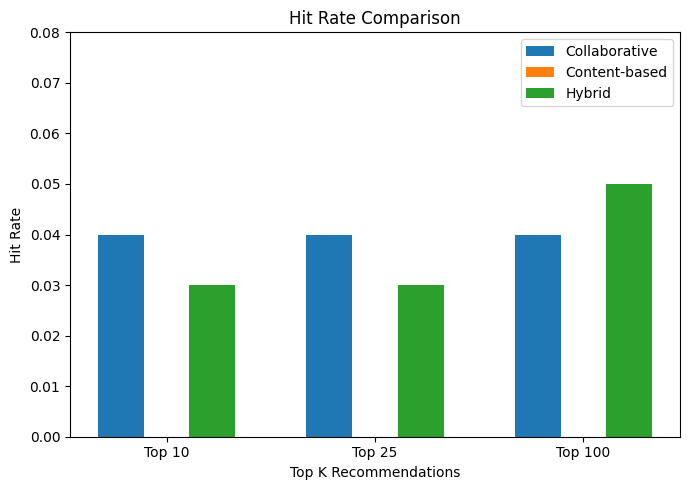

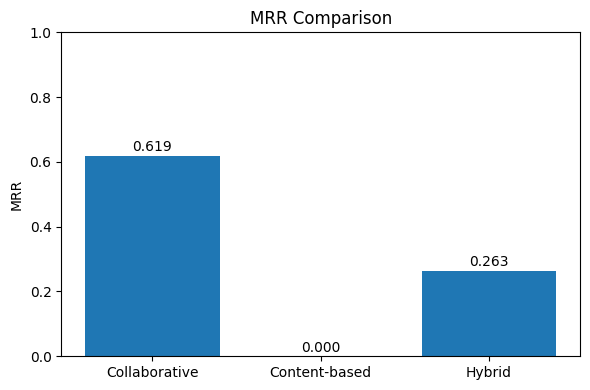

In [ ]:
labels = ["Top 10", "Top 25", "Top 100"]
x = np.arange(len(labels))
width = 0.22

plt.figure(figsize=(7, 5))

plt.bar(x - width, collab_hit_rates, width=width, label="Collaborative")
plt.bar(x, content_hit_rates, width=width, label="Content-based")
plt.bar(x + width, hybrid_hit_rates, width=width, label="Hybrid")

plt.xticks(x, labels)
plt.xlabel("Top K Recommendations")
plt.ylabel("Hit Rate")
plt.title("Hit Rate Comparison")
plt.legend()
plt.ylim(0, 0.08)
plt.tight_layout()
plt.show()


# MRR comparison
plt.figure(figsize=(6, 4))

models = ["Collaborative", "Content-based", "Hybrid"]
mrr_values = [collab_mrr, content_mrr, hybrid_mrr]

plt.bar(models, mrr_values)

for i, v in enumerate(mrr_values):
    plt.text(x[i], v + 0.005, f"{v:.3f}", ha='center', va='bottom')

plt.ylabel("MRR")
plt.title("MRR Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()